# Descriptive notebook
# Table of Contents:
* [**Part 0**: Introduction: CitiBike Dataset](#ref0)
* [**Part 1**: Additonal datasets](#ref1)
* [**Part 2**. Research](#ref2)

In [1]:
import pandas as pd
import geopandas as gpd
from utils_appendix import load_bikeshare_frames
from utils_appendix import feature_engineering
from importlib import reload
reload(feature_engineering)
reload(load_bikeshare_frames)
%matplotlib inline
import matplotlib.pyplot as plt

# Part 0: Introduction CitiBike Dataset <a id="ref0"></a>

In this descriptive notebook a first analysis of the dataset and possible extra datasets will be made. The data gives us information about the pickups of citybikes in NY. All the pickups in NY are registred together with the type of user, start and end time of the trip and location. We will base our prediction challenge on this data. In order to achieve the exploratory component, extra variables such as weather and holidays will be added to make our predictions more accurate.

#### Loading and preprocessing the given dataset:
The function load_concat_multiple_csvs, distributes the loading via typecast_csv_to_pd_dataframe() over multiple cpu-processes.
In total, 76 csvs and 100 millions lines get loaded in around 30 seconds.
Columns from multiple years had to be standartized into the same column names and type casted, and preprocessed. For example the time columns got casted to UTC and datetime64 types.

In [2]:
csvs = load_bikeshare_frames.list_working_csvs()
#df = load_bikeshare_frames.typecast_csv_to_pd_dataframe("./data_raw/201509-citibike-tripdata.csv")
df = load_bikeshare_frames.load_concat_multiple_csvs(csvs)
time = %timeit -n 1 -r 1  load_bikeshare_frames.load_concat_multiple_csvs(csvs)
df.shape

listed paths to 76 csvs
attemp loading 76 csvs on 12 cpu processes
attemp loading 76 csvs on 12 cpu processes
23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


(100466029, 15)

Lets take a look at the data. To make some good predictions all the data from 2014 to 2020 will be used to train, validate and test our models. This data set contains 100 million lines. Adding the distance of a trip as an extra variable can be useful, consequently, we added an extra column with the distance per trip.
The target variable is the amount of trips per hour. So the data has to be modified to take this feature into account. The  modified df will therefore contain the number of pickups per hour and the averages of the other parameters. In addition, the number of woman, men and unknown will be counted. 

In [3]:
# analyse the type of our data 
df.dtypes

tripduration                           Int32
starttime                datetime64[ns, UTC]
stoptime                 datetime64[ns, UTC]
startstationid                         Int32
startstationname                      string
startstationlatitude                 Float32
startstationlongitude                Float32
endstationid                           Int32
endstationname                        string
endstationlatitude                   Float32
endstationlongitude                  Float32
bikeid                                 Int32
usertype                            category
birthyear                              Int32
gender                                 Int32
dtype: object

In [4]:
# Compute the distance of each trip with the longitude and latitude of the start and end stations
# we used the havesine formula : commonly used to find the shortest distance between 2 points on earth 
# we are aware that it is an estimation : the trips will be longer due to road use

reload(feature_engineering)
df["feat_distance_trip"] = feature_engineering.haversine(
    lat1 = df.startstationlatitude.values.astype(float),
    lon1 = df.startstationlongitude.values.astype(float),
    lat2 = df.endstationlatitude.values.astype(float),
    lon2 = df.endstationlongitude.values.astype(float), to_radians=True
)
df.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,feat_distance_trip
starttime,,,,,,,,,,,,,,,,
2014-09-01 04:00:25+00:00,2828,2014-09-01 04:00:25+00:00,2014-09-01 04:47:33+00:00,386,Centre St & Worth St,40.714947,-74.002342,450,W 49 St & 8 Ave,40.762272,-73.987885,15941,Subscriber,1980,1,5.407473
2014-09-01 04:00:28+00:00,368,2014-09-01 04:00:28+00:00,2014-09-01 04:06:36+00:00,387,Centre St & Chambers St,40.712734,-74.004608,2008,Little West St & 1 Pl,40.705692,-74.016777,18962,Subscriber,1982,1,1.291864
2014-09-01 04:00:40+00:00,2201,2014-09-01 04:00:40+00:00,2014-09-01 04:37:21+00:00,386,Centre St & Worth St,40.714947,-74.002342,441,E 52 St & 2 Ave,40.756016,-73.967415,15982,Subscriber,1968,1,5.438799
2014-09-01 04:00:41+00:00,322,2014-09-01 04:00:41+00:00,2014-09-01 04:06:03+00:00,167,E 39 St & 3 Ave,40.748901,-73.976051,528,2 Ave & E 31 St,40.742908,-73.977058,19081,Subscriber,1961,1,0.672506
2014-09-01 04:00:59+00:00,1693,2014-09-01 04:00:59+00:00,2014-09-01 04:29:12+00:00,223,W 13 St & 7 Ave,40.737816,-73.999947,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976326,20836,Subscriber,1978,1,6.331913


In [5]:
# extracts pickups per hour and related feature from the citybike dataset
feature_engineering.pickups_by_hour??

Signature: feature_engineering.pickups_by_hour(df)
Source:   
def pickups_by_hour(df):
    """
    extract hourly sampled from dataframe:
    - pickups per hour for NYC
    - mean age of hourly pickups
    - mean distance of riders 
    - mean duration for a ride
    """
    # selecting targeted features 
    columns_used = ["birthyear", "gender", "feat_distance_trip", "starttime", "stoptime"]
    df_resampled = df.loc[:,columns_used].resample('H')
    
    # computing number of pickups for NYC per hour
    pickups_by_hour = df_resampled["birthyear"].count().rename("pickups_per_h")

    # computing mean birthyear of pickups
    age = df_resampled["birthyear"].mean().rename("feat_pickupmeanbyear")

    # computing pickups splitted by gender
    pickup_gender = df_resampled.gender.value_counts().unstack(level=1).rename(
        columns={0:"feat_pickupgender_unk",1:"feat_pickupgender_m",2:"feat_pickupgender_f"}
    )
    # computing mean distance per timeslot
    distance_trip = df_resamp

In [6]:
reload(feature_engineering)
pickups = feature_engineering.pickups_by_hour(df)
pickups

,pickups_per_h,feat_pickupgender_unk,feat_pickupgender_m,feat_pickupgender_f,feat_pickupmeanbyear,feat_meantriptime,feat_meandistancetrip
starttime,,,,,,,
2014-09-01 04:00:00+00:00,253,59.0,209.0,44.0,1980.051383,1089.628205,1.697792
2014-09-01 05:00:00+00:00,146,32.0,126.0,20.0,1980.30137,980.955056,1.536078
2014-09-01 06:00:00+00:00,105,20.0,93.0,12.0,1979.933333,981.296000,1.634768
2014-09-01 07:00:00+00:00,65,24.0,55.0,9.0,1980.061538,804.204546,1.637914
2014-09-01 08:00:00+00:00,53,11.0,45.0,8.0,1977.471698,899.312500,1.720652
...,...,...,...,...,...,...,...
2021-01-01 00:00:00+00:00,1478,159.0,961.0,358.0,1982.29567,861.065050,1.752439
2021-01-01 01:00:00+00:00,982,122.0,610.0,250.0,1982.034623,1113.310770,1.697623
2021-01-01 02:00:00+00:00,798,113.0,519.0,166.0,1982.199248,1738.617858,1.749607


# Part 1: Additonal datasets <a id="ref1"></a>

## Dates

Different kind of parameters could influence the use of the citibikes in NY. 
First, we calculate new features based **only on the dates** of our pickups dataset.  
To be able to feed it into our machine learning system, we perform a feature transform to continous (sin / cos) representations of the dayoftheyear and timeoftheday.  
Additionally, using pandas.tseries.holiday.usfederalholidaycalendar, we can get the public holidays for the US on a national level.

In [7]:
# get information about date and time
reload(feature_engineering)
df_time = feature_engineering.features_date_transform(
    pickups.index.to_series()
)
# feature_engineering.features_date_transform??
df_time

,ana_dayoftheyear,feat_dayoftheweek,ana_minuteofday,feat_isholiday,feat_dayoftheyear_sin,feat_dayoftheyear_cos,feat_minuteofday_sin,feat_minuteofday_cos
starttime,,,,,,,,
2014-09-01 04:00:00+00:00,244,0,0,True,-8.660254e-01,-0.5,0.000000,1.000000
2014-09-01 05:00:00+00:00,244,0,60,True,-8.660254e-01,-0.5,0.258819,0.965926
2014-09-01 06:00:00+00:00,244,0,120,True,-8.660254e-01,-0.5,0.500000,0.866025
2014-09-01 07:00:00+00:00,244,0,180,True,-8.660254e-01,-0.5,0.707107,0.707107
2014-09-01 08:00:00+00:00,244,0,240,True,-8.660254e-01,-0.5,0.866025,0.500000
...,...,...,...,...,...,...,...,...
2021-01-01 00:00:00+00:00,366,3,1140,False,-2.449294e-16,1.0,-0.965926,0.258819
2021-01-01 01:00:00+00:00,366,3,1200,False,-2.449294e-16,1.0,-0.866025,0.500000
2021-01-01 02:00:00+00:00,366,3,1260,False,-2.449294e-16,1.0,-0.707107,0.707107


## Weather

We would like to study the influence of some the weather as well as the impact of weekends and holidays. The weather parameters will in our opinion influence the use of the bikes througout the day. We acquired the weather data from the meteostat python package from the [JFK Airport Station](https://meteostat.net/en/station/74486) because airports datasets have very complete and consistent data and JFK is very close to NY city center. Hourly historic weather data will be extracted from 2013 to 2020. 

From the weather dataset, features are extracted, as the hourly temperature, the humidity rate, the percipitation and the wind speed, and also the catigorization into coco weather categories (gives information about weather it is sunny, cloudy, foggy, rainy...).

In [8]:
# getting the weather datasets
reload(feature_engineering)
weather_raw = feature_engineering.get_nyc_weather_stats()
weather = feature_engineering.nyc_weather_feature_frame(weather_raw)
weather

,feat_w_temp,feat_w_rhum,feat_w_prcp,feat_w_wspd,feat_w_c_excellent_weather,feat_w_c_cloudy,feat_w_c_fog,feat_w_c_rain,feat_w_c_snow,feat_w_c_storm
time,,,,,,,,,,
2013-06-01 00:00:00+00:00,22.8,68.0,0.0,25.9,False,False,False,False,False,False
2013-06-01 01:00:00+00:00,21.7,73.0,0.0,20.5,False,False,False,False,False,False
2013-06-01 02:00:00+00:00,20.6,78.0,0.0,16.6,False,False,False,False,False,False
2013-06-01 03:00:00+00:00,18.9,84.0,0.0,11.2,False,False,False,False,False,False
2013-06-01 04:00:00+00:00,18.9,84.0,0.0,7.6,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 20:00:00+00:00,6.7,68.0,0.0,18.4,False,False,False,True,False,False
2020-12-31 21:00:00+00:00,6.1,65.0,0.0,20.5,False,True,False,False,False,False
2020-12-31 22:00:00+00:00,5.6,59.0,0.0,24.1,False,True,False,False,False,False


In [9]:
# uncomment for our source code
# feature_engineering.get_nyc_weather_stats??
# feature_engineering.nyc_weather_feature_frame??

## Sun angle

Another useful feature is the angle of the sun. The relationship of daylight and a given hour has in a non-linear relationship to the day of the year. Therefore, sun angle can allow us to know if it is day or night. Some bike riders may refrain to cycle in unsafe neigborhoods at 8pm in November (after dark), while in August before dusk, they would rent a bike.

In [10]:
reload(feature_engineering)
angles =  feature_engineering.vectorized_get_sun_angle_nyc()
# uncomment for our source code
# feature_engineering.vectorized_get_sun_angle_nyc??
angles.head()

,feat_sun_angle
starttime,
2013-05-30 00:00:00+00:00,2.297051
2013-05-30 01:00:00+00:00,-7.323119
2013-05-30 02:00:00+00:00,-15.654090
2013-05-30 03:00:00+00:00,-22.167300
2013-05-30 04:00:00+00:00,-26.269405


In [11]:
# Merge all datasets
full_df = pickups.join(
    [df_time,
    weather,
    angles]
)
full_df

,pickups_per_h,feat_pickupgender_unk,feat_pickupgender_m,feat_pickupgender_f,feat_pickupmeanbyear,feat_meantriptime,feat_meandistancetrip,ana_dayoftheyear,feat_dayoftheweek,ana_minuteofday,...,feat_w_rhum,feat_w_prcp,feat_w_wspd,feat_w_c_excellent_weather,feat_w_c_cloudy,feat_w_c_fog,feat_w_c_rain,feat_w_c_snow,feat_w_c_storm,feat_sun_angle
starttime,,,,,,,,,,,,,,,,,,,,,
2014-09-01 04:00:00+00:00,253.0,59.0,209.0,44.0,1980.051383,1089.628205,1.697792,244.0,0.0,0.0,...,85.0,0.0,20.5,False,False,False,False,False,False,-39.280308
2014-09-01 05:00:00+00:00,146.0,32.0,126.0,20.0,1980.30137,980.955056,1.536078,244.0,0.0,60.0,...,82.0,0.0,18.4,False,False,False,False,False,False,-40.959083
2014-09-01 06:00:00+00:00,105.0,20.0,93.0,12.0,1979.933333,981.296000,1.634768,244.0,0.0,120.0,...,88.0,0.0,11.2,False,False,False,False,False,False,-38.815527
2014-09-01 07:00:00+00:00,65.0,24.0,55.0,9.0,1980.061538,804.204546,1.637914,244.0,0.0,180.0,...,88.0,0.0,11.2,False,False,False,False,False,False,-33.295989
2014-09-01 08:00:00+00:00,53.0,11.0,45.0,8.0,1977.471698,899.312500,1.720652,244.0,0.0,240.0,...,88.0,0.0,14.8,False,False,False,False,False,False,-25.295182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01 00:00:00+00:00,1478.0,159.0,961.0,358.0,1982.29567,861.065050,1.752439,366.0,3.0,1140.0,...,57.0,0.0,22.3,False,True,False,False,False,False,-25.940774
2021-01-01 01:00:00+00:00,982.0,122.0,610.0,250.0,1982.034623,1113.310770,1.697623,366.0,3.0,1200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-37.256852
2021-01-01 02:00:00+00:00,798.0,113.0,519.0,166.0,1982.199248,1738.617858,1.749607,366.0,3.0,1260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-48.545090


## Filling up missing values

In [12]:
#to know what data was missing before filling it up
print("missing before filling: \n", full_df.index.difference(full_df.dropna().index))

# fill columns with the last known value : we do this for all variables except when pickups_per_h is missing 
columns = pd.Series(full_df.columns).str.contains('[^pickups_per_h]').astype("bool").values
full_df.loc[:, columns] = full_df.loc[:, columns].ffill(limit=4).bfill(limit=4)

#to make sure that no more data is missing
missing_now = full_df.index.difference(full_df.dropna().index)
print("missing after filling: \n", missing_now)

missing before filling: 
 DatetimeIndex(['2016-02-03 23:00:00+00:00', '2016-05-01 16:00:00+00:00',
               '2021-01-01 01:00:00+00:00', '2021-01-01 02:00:00+00:00',
               '2021-01-01 03:00:00+00:00', '2021-01-01 04:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='starttime', freq=None)
missing after filling: 
 DatetimeIndex([], dtype='datetime64[ns, UTC]', name='starttime', freq='H')


# Part 2: Initial Research <a id="ref2"></a>

We made some graphics in order to identify tendencies of our variables and relations between the new variables and the number of pickups.

In [13]:
#declaration of the parameters used for plotting our data
day = pd.date_range(start="2015-09-01", end="2015-09-10", freq="H", tz="US/Eastern")
year = pd.date_range(start="2015-01-01", end="2015-12-31", freq="d", tz="US/Eastern")
years = pd.date_range(start="2015-01-01", end="2018-12-31", freq="w", tz="US/Eastern")

## Temperature

In the plot bellow we can see the temperature in function of the days. We can observe the cummulation of a ciclyc temperature change during a single day but also the change of temperature from one day to another. 

Text(0.5, 1.0, 'Temperature throughout the first 10 days of semptember 2015')

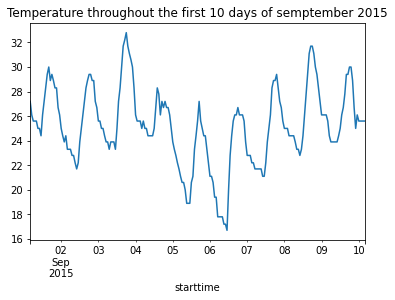

In [14]:
full_df.loc[day,"feat_w_temp"].plot()
plt.title("Temperature throughout the first 10 days of semptember 2015")

When doing this over a year, we can identify variations in temperature that could have an influence on bike use. As expected, temperatures are lower from december to april and higher from may to september. 

We can also note that the winters of 2015 and 2018 are colder than the rest and the summers tend to have the same temperatures up to 25 degrees. 

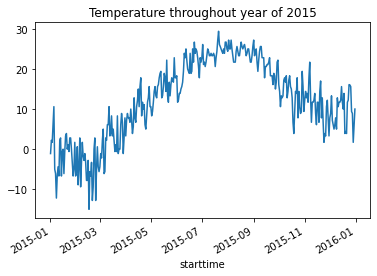

Text(0.5, 1.0, 'Temperature throughout years from 2015 to 2019')

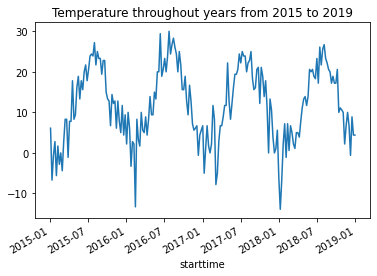

In [15]:
full_df.loc[year,"feat_w_temp"].plot()
plt.title("Temperature throughout year of 2015")
plt.show()

full_df.loc[years,"feat_w_temp"].plot()
plt.title("Temperature throughout years from 2015 to 2019")

As we can see in the graphic below, the higher the temperature is in NY, the most users tend to pickups bikes. The relationship seems linear. Thus, knowing the temperature forecast for the future helps to forecast the city-wide bike demand. 
In order to observe only the impact of temperatures we narrowed our plotting to only noon datapoints. The problem we could have faced otherwise is that the temperatures are lower at night and people tend to take the bus less at night because they are sleeping. 
It is interesting to see that if the temperatures get too high the number of pickups decreases. 

Text(0.5, 1.0, 'Number of pickups at noon as a function of temperature')

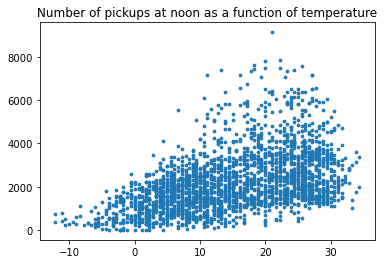

In [16]:
# take only noon
slice_noon = pd.date_range(start="2014-09-01 12:00:00", end="2020-12-31 12:00:00", freq="D", tz="US/Eastern")

_ = plt.scatter(full_df.loc[slice_noon, "feat_w_temp"], full_df.loc[slice_noon, "pickups_per_h"],s=7.5)
plt.title("Number of pickups at noon as a function of temperature")

## Weather conditions

,Weather typology,Number of days
0,feat_w_c_excellent_weather,8265
1,feat_w_c_cloudy,11507
2,feat_w_c_fog,4747
3,feat_w_c_rain,16608
4,feat_w_c_snow,2888
5,feat_w_c_storm,523


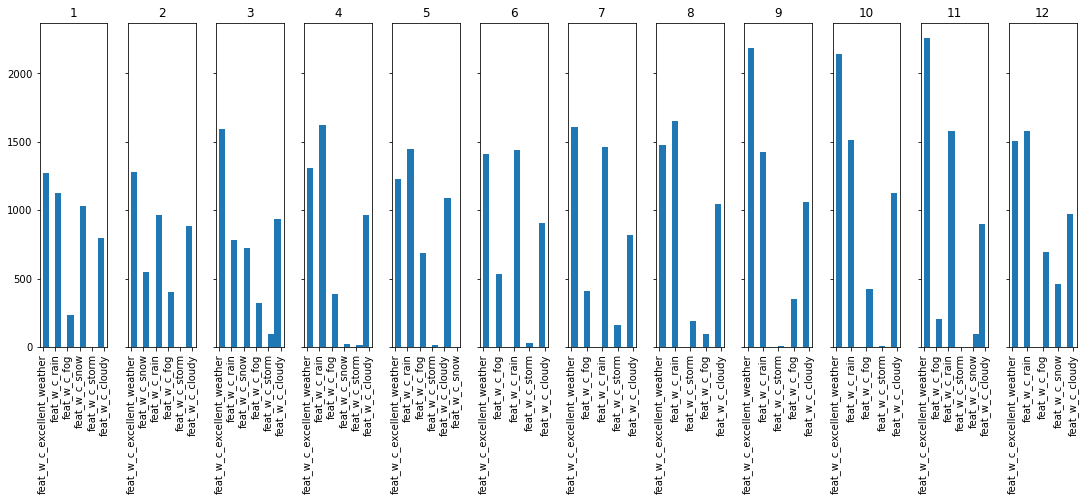

In [17]:
columns_weather = pd.Series(full_df.columns).str.contains('feat_w_c_').astype("bool").values
weather_stats = full_df.loc[:,columns_weather].idxmax(axis=1)
_ = weather_stats.hist(by = weather_stats.index.month, layout=(1,12), figsize=(18,6), sharey=True)

def count(weather_condition):
    return full_df.loc[:, weather_condition].value_counts()[True]

counts = pd.array([(name, count(name)) for name in [
"feat_w_c_excellent_weather",  "feat_w_c_cloudy",  "feat_w_c_fog",  "feat_w_c_rain",  "feat_w_c_snow" , "feat_w_c_storm"]])
pd.DataFrame(counts).rename(columns={0:"Weather typology",1:"Number of days"})


As we can see, NYC has mostly rainy and cloudy weather. Most snow is in Dec-Mar, and Sept-Nov have surprisingly often excellent weather. They are very few storm days. 

As expected, if we have high pickups, we can almost be certain it was good weather.

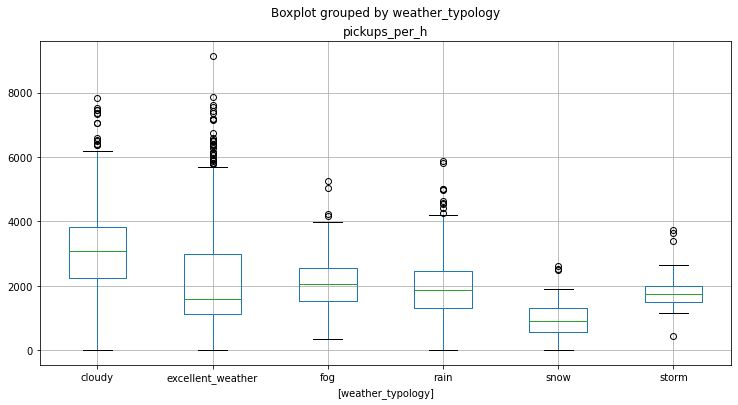

In [18]:
noon_sliced = full_df.loc[slice_noon]
columns_weather = pd.Series(noon_sliced.columns).str.contains('feat_w_c_').astype("bool").values
we = pd.concat(
    [noon_sliced.loc[:,columns_weather].rename(columns=lambda x: x.replace("feat_w_c_","")).idxmax(axis=1).rename("weather_typology"), 
     noon_sliced.pickups_per_h],
    axis=1
)
we.boxplot(by="weather_typology", figsize=(12,6));

## Sun angle 

We decided to take the sun angle to our additional data because it is an easy numerical way of knowing if it is day or night. 

On the grapphic below, the variation of the sun angle can be observed. No real variation can be seen in the first ten days of september. If we do this for the whole year and the mean per day would be taken the season can easily be distinguished.

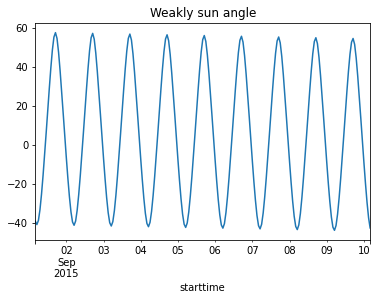

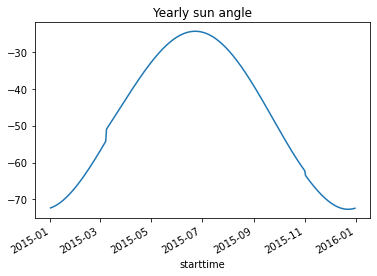

In [19]:
days_sept15 = pd.date_range(start="2015-09-01", end="2015-09-10", freq="H", tz="US/Eastern")
full_df.loc[days_sept15,"feat_sun_angle"].plot()
plt.title("Weakly sun angle") 
plt.show()
full_df.loc[year,"feat_sun_angle"].plot()
plt.title("Yearly sun angle")
plt.show()
# full_df.loc[years,"feat_sun_angle"].plot()
# plt.show()

## Dates

Monthly boxplots of the number of pickups allow us to see that some months have higher bike use than others : this is probably related to weather conditions but also to sunlight hours throughout the day.

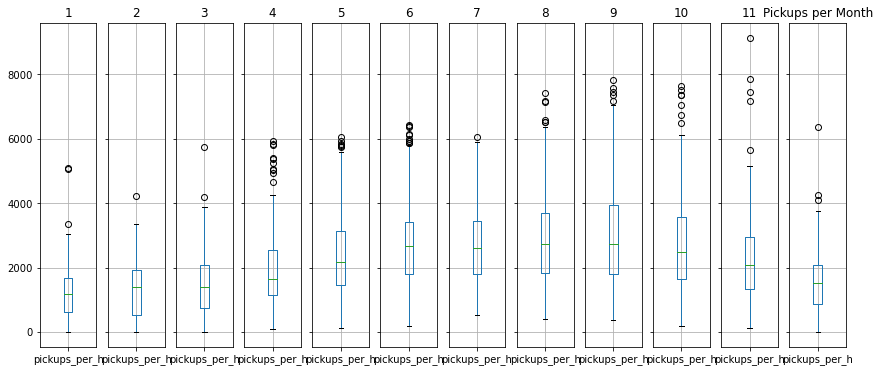

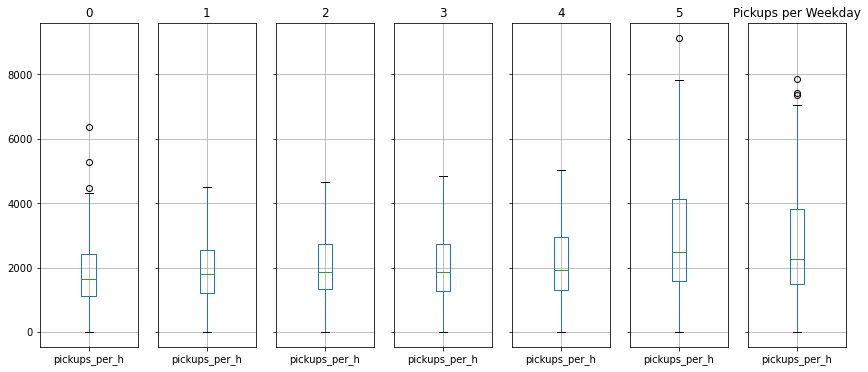

In [20]:
# Group demand by month -> boxpot

_ = noon_sliced.groupby(noon_sliced.index.month).boxplot(column="pickups_per_h", layout=(1,12), figsize=(14,6))
plt.title("Pickups per Month")
plt.show()
_ = noon_sliced.groupby(noon_sliced.index.dayofweek).boxplot(column="pickups_per_h", layout=(1,7), figsize=(14,6))
plt.title("Pickups per Weekday")
plt.show()

Lastly the pickups in function of the day can be investigated. 
In the graphic below, three days have a clearly smaller use than the others. This is probably due to the weekend followed by a holiday, which most New Yorkers use to drive for labour day weekend on the countryside or to close by State Parks. If we compare it with the graphic that plots weekends and holidays our hipothesis is confirmed.

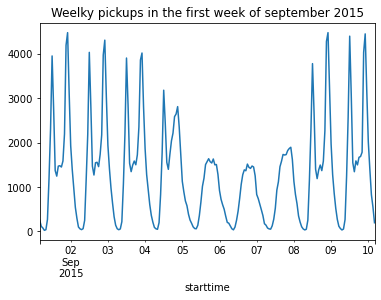

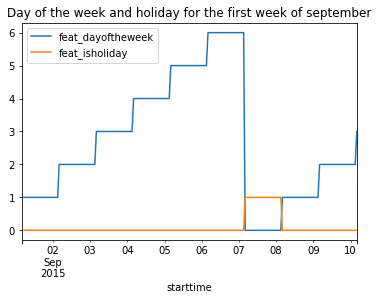

In [21]:
full_df.loc[days_sept15,"pickups_per_h"].plot()
plt.title("Weelky pickups in the first week of september 2015")
plt.show()
full_df.loc[days_sept15, ["feat_dayoftheweek","feat_isholiday"]].astype(int).plot()
plt.title("Day of the week and holiday for the first week of september")
plt.show()

Finaly, in the graphs below, the number of pickups are plotted over a whole year. Therefore, a peak in pickups can be seen in november and a decrease in use can be found during the winter months. 
In the last graphic we can appreciate the increase of the number of pickups throughout the years, probably due to the popularisation of this transport means.

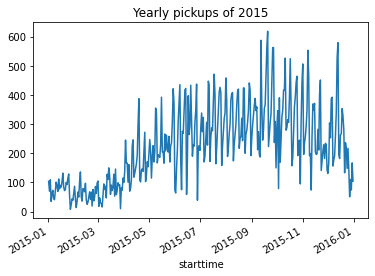

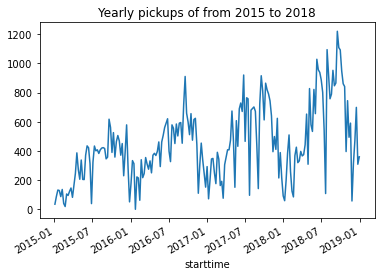

In [22]:
full_df.loc[year,"pickups_per_h"].plot()
plt.title("Yearly pickups of 2015")
plt.show()
full_df.loc[years, "pickups_per_h"].plot()
plt.title("Yearly pickups of from 2015 to 2018");